<a href="https://colab.research.google.com/github/head1ton/ML_Analysis/blob/master/Spending_%24%24%24_for_MS_in_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install eli5

     |████████████████████████████████| 112kB 2.7MB/s 


In [3]:
from plotly.subplots import make_subplots
from IPython.display import display, HTML
from collections import Counter
from plotly import tools
import plotly
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import folium
from folium import plugins

# 요거 안 넣으면 plotly.graph_ojbs 가 안나옴.
import plotly.io as pio
pio.renderers.default = 'colab'

# Graphics in retina format
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = 8, 5

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('ignore', category=FutureWarning)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score
import eli5

df = pd.read_csv('./multiple_choice_responses.csv', low_memory=False)
df = df[~df['Q5'].isin(["Student", "Not employed"])] # 학생과 백수는 제외

Using TensorFlow backend.


In [4]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par..

In [5]:
df['Q13_Part_1'].value_counts()

Udacity                                                                                                                     2278
On which platforms have you begun or completed data science courses? (Select all that apply) - Selected Choice - Udacity       1
Name: Q13_Part_1, dtype: int64

In [0]:
# Reference [::-1] 
# 반대로 뒤집는 거 (아래는 예)
# xaxis[::-1] :  ['Other', 'None', 'University Courses (resulting in a university degree)', 'LinkedIn Learning', 'Udemy', 'Fast.ai', 'Kaggle Courses (i.e. Kaggle Learn)', 'DataQuest', 'DataCamp', 'edX', 'Coursera', 'Udacity']
# xaxis :  ['Udacity', 'Coursera', 'edX', 'DataCamp', 'DataQuest', 'Kaggle Courses (i.e. Kaggle Learn)', 'Fast.ai', 'Udemy', 'LinkedIn Learning', 'University Courses (resulting in a university degree)', 'None', 'Other']

In [0]:
def summate_columns(col, xaxis_def=None):
    xaxis, yaxis1 = [], []
    for i in range(1, 20):
        if col+'_Part_'+str(i) not in df:
            break
        
        doc = dict(df[col+'_Part_'+str(i)].value_counts())
        if len(doc) > 0:
            key = list(doc.keys())[0]
        else:
            continue 
        xaxis.append(key)
        
        if key in doc:
            yaxis1.append(doc[key])
        else:
            yaxis1.append(0)
            
    if xaxis_def != None:
        xaxis = xaxis_def
    
    xaxis = xaxis[::-1]
    xaxis = [_.split("(")[0]+"    " for _ in xaxis]
    yaxis1 = [x*100/len(df) for x in yaxis1][::-1]

    temp_df = pd.DataFrame()
    temp_df['xaxis'] = xaxis
    temp_df['yaxis'] = yaxis1
    temp_df = temp_df.sort_values("yaxis")
    temp_df['colors'] = ['#fad46b']*len(temp_df)
    colors = np.array(temp_df['colors'])
    colors[-3], colors[-2], colors[-1] = "#97c6e8", "#97c6e8", "#97c6e8"
    colors[-4] = "red"
    
    annotations = []
    for yd, xd in zip(xaxis, yaxis1):
        annotations.append(dict(xref='x', yref='y',
                            x=xd+2, y=yd,
                            text=str(round(xd, 1)) + '%',
                            font=dict(family='Arial', size=14, color='black'),
                            showarrow=False))
    
    fig = go.Figure(data=[go.Bar(name='', y=temp_df['xaxis'], x=temp_df['yaxis'], orientation='h', marker=dict(color=colors, opacity=0.6))], 
                    layout = go.Layout(title="Sources of Learning Data Science", plot_bgcolor='#fff', paper_bgcolor='#fff', margin=dict(l=100), width=900, height=500, legend=dict(orientation="h", x=0.1, y=1.1)))
    fig.update_layout(barmode='group')
    
    annotations += [go.layout.Annotation(x=40, y=9, xref="x", yref="y", text="(Most Popular)", showarrow=False, arrowhead=7, ax=0, ay=-40)]
    
    fig.update_layout(annotations=annotations)
    fig.update_xaxes(showgrid=False, zeroline=False, title="% of respondents")
    fig.update_yaxes(showgrid=False, zeroline=False)
    fig.add_shape(go.layout.Shape(type="rect", xref="x", yref="paper", x0=22, x1=48.6, y0=0.75, y1=1, fillcolor="gray", opacity=0.2, layer="below", line_width=0))
    fig.show()

In [8]:
summate_columns("Q13")

In [9]:
d = {
        'Gain More Knowledge': 69.7,
        'Better Job Roles': 34.5,
        'Personal Goal': 26.2,
        'Career Change': 41.8,
        'Better Salary': 43.5,
}

xx = ["Personal Goal", "Better Salary", "Gain More Knowledge", "Better Job Roles", "Career Change"]
xx = [_ + "<br>(" +str(d[_])+ "%)" for _ in xx]
yy = [""]*len(d)
zz = [13.7, 63, 100, 40, 56]
cc = ['red', 'green', 'purple', 'orange', "blue"] 

trace1 = go.Scatter(x = xx, y = [""]*len(d), mode='markers', name="", marker=dict(color=cc, opacity=0.4, size = zz))
layout = go.Layout(barmode='stack', height=300, margin=dict(l=100), title='Reasons for pursuing University Degrees',
                   legend = dict(orientation="h", x=0.1, y=1.15), plot_bgcolor='#fff', paper_bgcolor='#fff', 
                   showlegend=False)

fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [10]:
university_data = """CMU Tepper	67575	24
UC Berkeley	66150	20
Georgia Tech	9900	23
Illinois-Urbana	19200	17.5
South California	55886	24
Wisconsin	30600	17.5
Boston Metropolitan	34400	24
Johns Hopkins	53740	17.5
Pennsylvania State	29250	17.5
Northwestern SPS	53148	18
Rutgers	23136	24
UCD Dublin	7575	36
Texas A&M	65000	24
Arizona State	39622	15
Northeastern	34200	24
Ohio	35250	20
Rice	129000	24
Indiana Bloomington	15172	18
Notre Dame	48000	21
IIT Chicago	30985	16
Syracuse	54000	24
California Riverside	24990	13
Iowa State	24000	21
Oregon State	23445	17.5
Missouri	34000	24
CUNY SPS	13200	17.5
American	54186	15
Oklahoma	26103	14
Colorado	39450	24
Oklahoma State	33990	24
Baker College	17100	17.5
Bay Path	29340	24
Bellevue	20700	17.5
Blanchardstown	2320	24
Capella	33360	12
Central Connecticut	21681	17.5
Colorado Technical	28080	24
DePaul	43160	17.5
DS TechInstitute	7900	9
Dakota State	13320	10
Elmhurst College	25350	24
Full Sail	28008	12
La Salle	26250	20
Lewis	26235	24
Maryville St. Louis	22950	17.5
Phoenix	29316	17.5
Regis	25560	17.5
Saint Mary's College	31946	24
South Dakota State	13320	12
Saint Joseph's	17520	24
Southern Methodist	57084	28
Southern New Hampshire	22572	15
Slippery Rock	16269	10
Alabama Huntsville	21810	12
Maryland College	24984	17.5
Villanova	43400	24
West Virginia	30690	17.5
Northcentral	30530	23
Edinburgh Napier	9060	33
Drexel	56925	24
Merrimack College	28320	16
Varna Free	5391	12
Johnson & Wales	23744	24
Kent State	21524	12"""

university_data = university_data.split("\n")
udf = pd.DataFrame()
udf['name'] = [_.split("	")[0] for _ in university_data]
udf['tution'] = [float(_.split("	")[1]) for _ in university_data]
udf['months'] = [float(_.split("	")[2]) for _ in university_data]

udf

,name,tution,months
0,CMU Tepper,67575.0,24.0
1,UC Berkeley,66150.0,20.0
2,Georgia Tech,9900.0,23.0
3,Illinois-Urbana,19200.0,17.5
4,South California,55886.0,24.0
...,...,...,...
59,Drexel,56925.0,24.0
60,Merrimack College,28320.0,16.0
61,Varna Free,5391.0,12.0
62,Johnson & Wales,23744.0,24.0


In [11]:
udf['name']

0            CMU Tepper
1           UC Berkeley
2          Georgia Tech
3       Illinois-Urbana
4      South California
            ...        
59               Drexel
60    Merrimack College
61           Varna Free
62      Johnson & Wales
63           Kent State
Name: name, Length: 64, dtype: object

In [12]:
udf1 = udf[udf['months'] > 6]
udf1 = udf1[udf1['months'] < 25]
udf1 = udf1[udf1['tution'] < 100000]
udf1['name1'] = udf1.apply(lambda x : "" if x['months'] in [9, 12, 17.5, 24] else x['name'], axis = 1)

udf1

,name,tution,months,name1
0,CMU Tepper,67575.0,24.0,
1,UC Berkeley,66150.0,20.0,UC Berkeley
2,Georgia Tech,9900.0,23.0,Georgia Tech
3,Illinois-Urbana,19200.0,17.5,
4,South California,55886.0,24.0,
5,Wisconsin,30600.0,17.5,
6,Boston Metropolitan,34400.0,24.0,
7,Johns Hopkins,53740.0,17.5,
8,Pennsylvania State,29250.0,17.5,
9,Northwestern SPS,53148.0,18.0,Northwestern SPS


In [13]:
fig = go.Figure([go.Bar(x=udf['name'], y=udf['tution'], orientation="v", name="Tution Fee", marker=dict(color="orange", opacity=0.5), ),
                 go.Scatter(x=udf['name'], name="Median Household Income", y=[59000]*len(udf), mode="lines", marker=dict(color="red"), line=dict(dash='dash')) ])
fig.update_layout(title="Tution Fee : University Degrees in Data Science", plot_bgcolor='#fff', paper_bgcolor='#fff', legend=dict(orientation="h", x=0.1, y=1.1), 
                 xaxis = dict(tickangle = 45), height=500)
fig.show()

fig = go.Figure([go.Bar(x=udf['name'], y=udf['months'], orientation="v", marker=dict(color="#3498d5", opacity=0.5, line=dict(color="#3498d5")), name="Duration"),
                 go.Scatter(x=udf['name'], y=[12]*len(udf), mode="lines", marker=dict(color="red"), line=dict(dash='dash'), name="1 Yr"), 
                 go.Scatter(x=udf['name'], y=[18]*len(udf), mode="lines", marker=dict(color="blue"), line=dict(dash='dash'), name="1.5 Yr"), 
                 go.Scatter(x=udf['name'], y=[24]*len(udf), mode="lines", marker=dict(color="orange"), line=dict(dash='dash'), name="2 Yr"), 
                ])
fig.update_layout(title="Duration : University Degrees in Data Science", plot_bgcolor='#fff', paper_bgcolor='#fff', legend=dict(orientation="h", x=0.1, y=1.1),
                   xaxis = dict(tickangle = 45), height=400)
fig.show()

In [14]:
# df[df['Q13_Part_10'] == "University Courses (resulting in a university degree)"].head()
# df[df['Q3'] == "United States of America"].head()
df['Q3'].value_counts()

India                                                   2972
United States of America                                2489
Other                                                    830
Brazil                                                   606
Japan                                                    580
Russia                                                   521
Germany                                                  435
United Kingdom of Great Britain and Northern Ireland     388
Spain                                                    359
Canada                                                   355
France                                                   333
China                                                    318
Nigeria                                                  235
Australia                                                223
Turkey                                                   221
Italy                                                    221
Taiwan                  

In [15]:
# Proportion of Individuals with University Degrees
key1 = "University Courses (resulting in a university degree)"
df1 = df[df['Q13_Part_10'] == key1]
df2 = df[df['Q13_Part_10'] != key1]

print(df1.shape)
print(df2.shape)

(3062, 246)
(11700, 246)


(25, 246)
(118, 246)


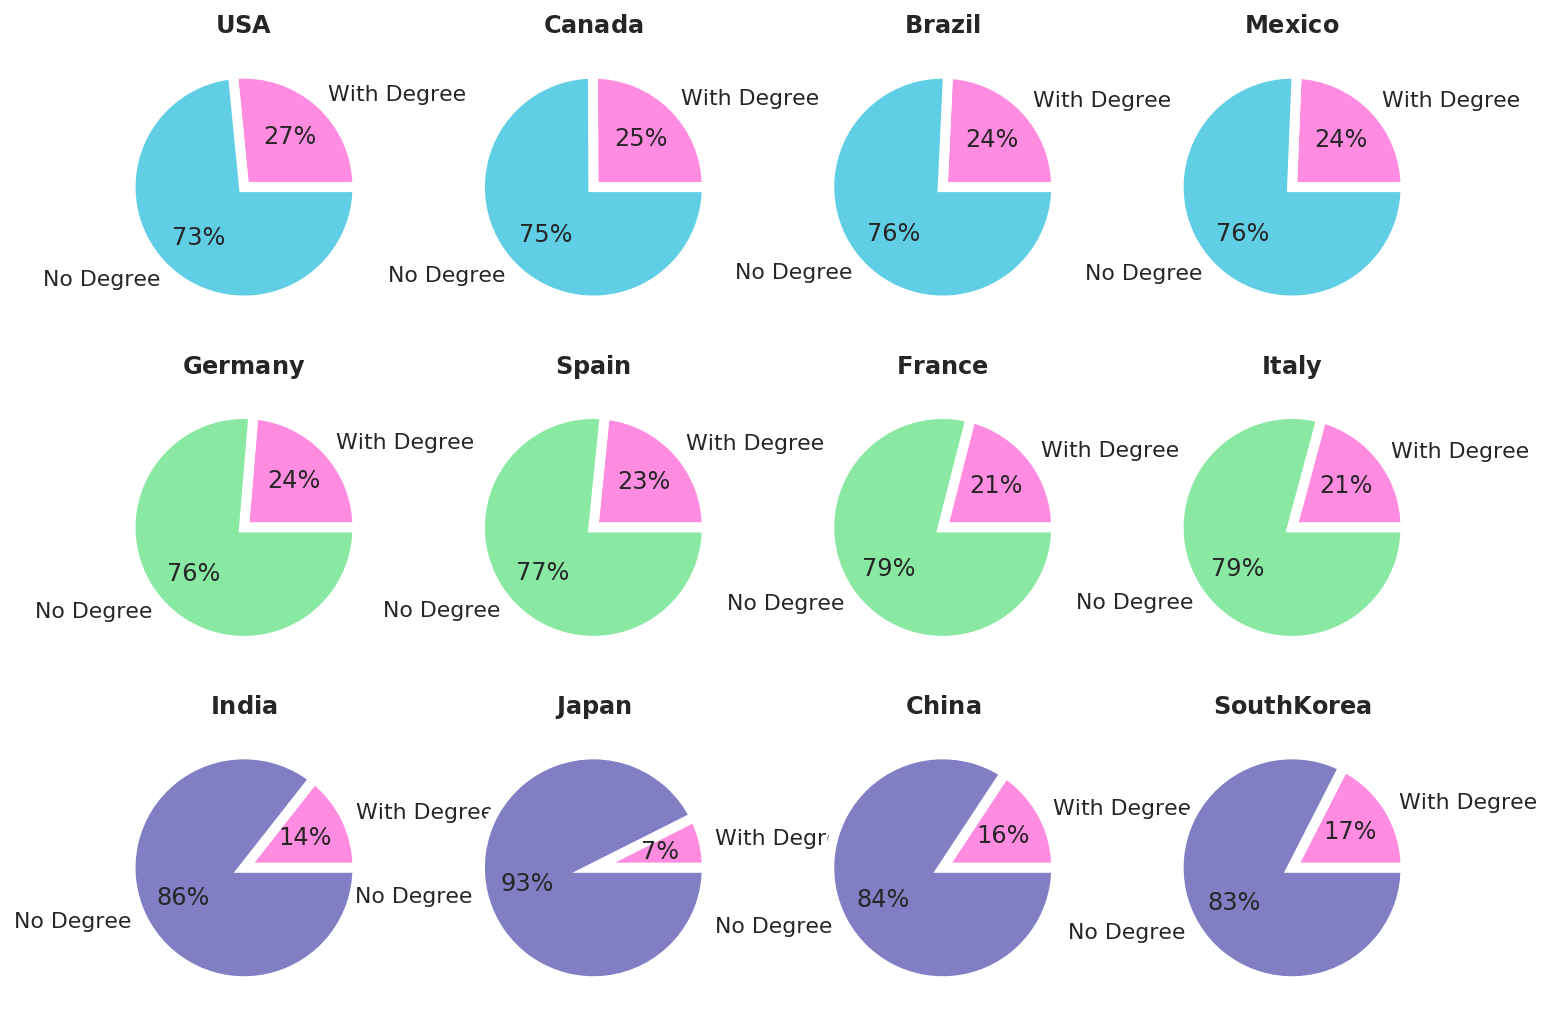

In [16]:
nations = ["United States of America", "Canada", "Brazil", "Mexico", "Germany", "Spain", "France", "Italy",
           "India", "Japan", "China", "South Korea"]
nation_map = {"United States of America": "USA", "United Kingdom of Great Britain and Northern Ireland": "UK"}
plt.figure(figsize=(12, 12))

vals = []
for j in range(len(nations)):
    country = nations[j]
    country_df = df[df['Q3'] == country]
    ddf1 = country_df[country_df['Q13_Part_10'] == key1]
    ddf2 = country_df[country_df['Q13_Part_10'] != key1]
    plt.subplot(4, 4, j+1)

    if j < 4:
        colors = ['#ff8ce0', '#60cfe6']
    elif j < 8:
        colors = ['#ff8ce0', '#89e8a2']
    else:
        colors = ['#ff8ce0', '#827ec4']
    
    vals.append(len(ddf1) / (len(ddf1) + len(ddf2)))

    plt.pie([len(ddf1), len(ddf2)],
            labels=['With Degree', 'No Degree'],
            autopct='%1.0f%%',
            colors=colors,
            wedgeprops={"linewidth":5, "edgecolor":"white"})
    if country in nation_map:
        country = nation_map[country]
    plt.title(r"$\bf{" + country + "}$")

print(ddf1.shape)
print(ddf2.shape)
    

In [0]:
col_yes = "#fad46b"
col_no = "#97c6e8"

def compute_stats(df, col, xaxis=None):
    agg_df = df[col].value_counts().to_frame()
    # print(agg_df)
    total = sum(agg_df[col])
    agg_df['percent'] = agg_df[col].apply(lambda x: 100*x / total)
    # print(agg_df)
    agg_df = agg_df.reset_index().rename(columns = {col: "count", 'index': col})
    # print(agg_df)
    agg_doc = {}
    if xaxis != None:
        for _ in xaxis:
            try:
                agg_doc[_] = agg_df[agg_df[col] == _]['percent'].iloc(0)[0]
                # print(agg_doc)
                # print(_)
            except:
                agg_doc[_] = 0
    return agg_doc

In [18]:
def plot_ver_bars(c, ht=500, annot=True):
    dxf1 = df1[df1['Q5'].isin(['Data Scientist'])]
    dxf2 = df2[df2['Q5'].isin(['Data Scientist'])]

    count_df1 = dxf1[dxf1['Q3'].isin([c])] # Data Scientist & country
    count_df2 = dxf2[dxf2['Q3'].isin([c])]
    col = "Q10"
    xaxis = ["$0-999", "1,000-1,999", "2,000-2,999", "3,000-3,999", "4,000-4,999", 
             "5,000-7,499", "7,500-9,999", "10,000-14,999", "15,000-19,999", 
             "20,000-24,999", "25,000-29,999", "30,000-39,999", "40,000-49,999", 
             "50,000-59,999", "60,000-69,999", "70,000-79,999", "80,000-89,999", 
             "90,000-99,999", "100,000-124,999", "125,000-149,999", "150,000-199,999", 
             "200,000-249,999", "250,000-299,999", "300,000-500,000", "> $500,000"]
    t1_doc = compute_stats(count_df1, col, xaxis=xaxis)
    t2_doc = compute_stats(count_df2, col, xaxis=xaxis)

    xaxis1 = ["$0K", "1 - 1K", "2 - 2K", "3 - 3K", "4 - 4K", "5 - 7.5K", "7.5 - 10K", 
              "10 - 15K", "15 - 20K", "20 - 25K", "25 - 30K", "30 - 40K", "40 - 50K", 
              "50 - 60K", "60 - 70K", "70 - 80K", "80 - 90K", "90 - 100K", "100 - 125K", 
              "125 - 150K", "150 - 200K", "200 - 250K", "250 - 300K", "300 - 500K", "> $500K"]

    fig = go.Figure(data=[
                          go.Bar(name='Without University Degree', x=xaxis1[7:], y=[t2_doc[_] for _ in xaxis][7:], 
                                 marker=dict(color=col_no, opacity=0.8)),
                          go.Bar(name='With University Degree', x=xaxis1[7:], y=[t1_doc[_] for _ in xaxis][7:],
                                 marker=dict(color=col_yes, opacity=0.8))
    ])
    fig.update_layout(barmode='group', title='Data Scientists in <b>' + c + "</b>",
                      yaxis=dict(title="% of respondents"),
                      xaxis=dict(title="US$"),
                      height=ht,
                      legend=dict(orientation='h', x=0.01, y=1.1),
                      plot_bgcolor='#fff', paper_bgcolor='#fff')
    fig.update_xaxes(showgrid=False, zeroline=False)
    fig.update_yaxes(showgrid=False, zeroline=False)
    if annot == True:
        fig.update_layout(annotations=[go.layout.Annotation(x=15.5, y=13, xref='x', yref='y',
                                                            text="More % of Individuals <br> Without University Degrees <br>Earning > $150K",
                                                            showarrow=True, arrowhead=7, ax=0, ay=-40),
                                       go.layout.Annotation(x=11, y=24, xref='x', yref='y', 
                                                            text="With University Degrees <br> Earning More",
                                                            showarrow=True, arrowhead=7, ax=0, ay=-40)])
        fig.add_shape(go.layout.Shape(
                    type="rect",
                    xref="x",
                    yref="paper",
                    x0=12.5,
                    x1=17.5,
                    y0=0.03,
                    y1=1,
                    fillcolor="red",
                    opacity=0.1,
                    layer="below",
                    line_width=0))
        fig.add_shape(go.layout.Shape(
                    type="rect",
                    xref="x",
                    yref="paper",
                    x0=10.5,
                    x1=12.4,
                    y0=0.5,
                    y1=1,
                    fillcolor="green",
                    opacity=0.1,
                    layer="below",
                    line_width=0))
    
    
    fig.show()
    return count_df1, count_df2

nations = ["United States of America", "Germany"]
c1, c2 = plot_ver_bars(nations[0])

In [19]:
c1.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
8,624,22-24,Female,-1,United States of America,Bachelor’s degree,Data Scientist,-1,"> 10,000 employees",20+,"We recently started using ML methods (i.e., mo...",Analyze and understand data to influence produ...,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"80,000-89,999",$0 (USD),NaN,Hacker News (https://news.ycombinator.com/),NaN,NaN,NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
67,474,25-29,Prefer not to say,-1,United States of America,Master’s degree,Data Scientist,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Experimentation and iteration to improve exist...,Do research that advances the state of the art...,NaN,NaN,-1,"200,000-249,999","> $100,000 ($USD)",NaN,NaN,NaN,NaN,"Course Forums (forums.fast.ai, etc)",NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,Udacity,Coursera,NaN,NaN,NaN,...,-1,NaN,NaN,NaN,Google Cloud Machine Learning Engine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,Auto-Keras,Auto-Sklearn,NaN,NaN,NaN,NaN,NaN,-1,MySQL,NaN,SQLite,NaN,NaN,NaN,NaN,NaN,NaN,Google Cloud SQL,NaN,NaN,-1
88,751,22-24,Male,-1,United States of America,Master’s degree,Data Scientist,-1,0-49 employees,3-4,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"125,000-149,999",$100-$999,NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)","Course Forums (forums.fast.ai, etc)","YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,NaN,NaN,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,-1,NaN,Coursera,edX,DataCamp,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,H20 Driverless AI,NaN,NaN,NaN,NaN,NaN,Auto_ml,NaN,NaN,NaN,NaN,-1,MySQL,NaN,NaN,NaN,Oracle Database,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
100,991,35-39,Prefer not to say,-1,United States of America,Master’s degree,Data Scientist,-1,50-249 employees,1-2,We are exploring ML methods (and may one day p...,Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,NaN,NaN,NaN,NaN,NaN,NaN,-1,"200,000-249,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,-1,NaN,NaN,edX,NaN,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
105,627,30-34,Male,-1,United States of America,Master’s degree,Data Scientist,-1,50-249 employee

In [20]:
c1['Q10'].head()

8        80,000-89,999
67     200,000-249,999
88     125,000-149,999
100    200,000-249,999
105    125,000-149,999
Name: Q10, dtype: object

In [21]:
c1['Q15'].value_counts()

3-5 years                    107
5-10 years                    81
10-20 years                   38
1-2 years                     28
20+ years                     26
< 1 years                      3
I have never written code      1
Name: Q15, dtype: int64

In [22]:
# Key Characteristics : Data Scientists earning > $150K
salaries = ["100,000-124,999", "125,000-149,999", "150,000-199,999", "200,000-249,999", "300,000-500,000"]
group1 = c1[c1["Q10"].isin(salaries)]
group2 = c2[c2['Q10'].isin(salaries)]

vc1 = group1['Q15'].value_counts().to_frame().reset_index()
vc1['percent'] = vc1['Q15'].apply(lambda x: 100*x / sum(vc1['Q15']))

vc2 = group2['Q15'].value_counts().to_frame().reset_index()
vc2['percent'] = vc2['Q15'].apply(lambda x: 100*x / sum(vc2['Q15']))

vc1.head()

,index,Q15,percent
0,5-10 years,68,35.051546
1,3-5 years,62,31.958763
2,10-20 years,30,15.463918
3,20+ years,19,9.793814
4,1-2 years,13,6.701031


In [23]:
order = ["< 1 years", "1-2 years", "3-5 years", "5-10 years", "10-20 years", "20+ years"]
doc1, doc2 = {}, {}
for _, r in vc1.iterrows():
    doc1[r['index']] = r['percent']
for _, r in vc2.iterrows():
    doc2[r['index']] = r['percent']

doc1

{'1-2 years': 6.701030927835052,
 '10-20 years': 15.463917525773196,
 '20+ years': 9.793814432989691,
 '3-5 years': 31.95876288659794,
 '5-10 years': 35.05154639175258,
 '< 1 years': 0.5154639175257731,
 'I have never written code': 0.5154639175257731}

In [0]:
trace1 = go.Bar(x=order, y=[doc1[_] for _ in order], name="", orientation="v", marker=dict(color=col_yes, opacity=0.8))
trace2 = go.Bar(x=order, y=[doc2[_] for _ in order], name="", orientation="v", marker=dict(color=col_no, opacity=0.8))

In [25]:
c1['Q1'].value_counts().to_frame()

,Q1
25-29,89
30-34,71
35-39,41
22-24,24
40-44,17
45-49,13
50-54,13
55-59,7
60-69,7
18-21,3


In [26]:
vc1 = group1['Q1'].value_counts().to_frame().reset_index()
vc1['percent'] = vc1['Q1'].apply(lambda x: 100*x / sum(vc1['Q1']))

vc2 = group2['Q1'].value_counts().to_frame().reset_index()
vc2['percent'] = vc2['Q1'].apply(lambda x: 100*x / sum(vc2['Q1']))

vc1.head()

,index,Q1,percent
0,25-29,56,28.571429
1,30-34,53,27.040816
2,35-39,35,17.857143
3,40-44,13,6.632653
4,45-49,10,5.102041


In [27]:
order = ['22-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59']
doc1, doc2 = {}, {}
for _, r in vc1.iterrows():
    doc1[r['index']] = r['percent']
for _, r in vc2.iterrows():
    doc2[r['index']] = r['percent']

doc1

{'18-21': 0.5102040816326531,
 '22-24': 5.1020408163265305,
 '25-29': 28.571428571428573,
 '30-34': 27.040816326530614,
 '35-39': 17.857142857142858,
 '40-44': 6.63265306122449,
 '45-49': 5.1020408163265305,
 '50-54': 3.5714285714285716,
 '55-59': 2.5510204081632653,
 '60-69': 3.061224489795918}

In [0]:
trace3 = go.Scatter(x=order, y=[doc1[_] for _ in order], name="", mode="lines+markers", marker=dict(color=col_yes, opacity=0.8))
trace4 = go.Scatter(x=order, y=[doc2[_] for _ in order], name="", mode="lines+markers", marker=dict(color=col_no, opacity=0.8))

In [29]:
### ML Exp

vc1 = group1['Q23'].value_counts().to_frame().reset_index()
vc1['percent'] = vc1['Q23'].apply(lambda x: 100*x / sum(vc1['Q23']))

vc2 = group2['Q23'].value_counts().to_frame().reset_index()
vc2['percent'] = vc2['Q23'].apply(lambda x: 100*x / sum(vc2['Q23']))

vc1.head()

,index,Q23,percent
0,5-10 years,41,21.354167
1,2-3 years,39,20.312500
2,3-4 years,37,19.270833
3,4-5 years,29,15.104167
4,1-2 years,19,9.895833


In [30]:
order = ['< 1 years', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-15 years', '15-20 years', '20+ years']
doc1, doc2 = {}, {}
for _, r in vc1.iterrows():
    doc1[r['index']] = r['percent']
for _, r in vc2.iterrows():
    doc2[r['index']] = r['percent']

doc1

{'1-2 years': 9.895833333333334,
 '10-15 years': 7.8125,
 '2-3 years': 20.3125,
 '20+ years': 5.208333333333333,
 '3-4 years': 19.270833333333332,
 '4-5 years': 15.104166666666666,
 '5-10 years': 21.354166666666668,
 '< 1 years': 1.0416666666666667}

In [0]:
trace5 = go.Bar(x=order, y=[doc1[_] if _ in doc1 else 0 for _ in order], name="With University Degree", orientation="v", marker=dict(color=col_yes, opacity=0.8))
trace6 = go.Bar(x=order, y=[doc2[_] if _ in doc1 else 0 for _ in order], name="Without University Degree", orientation="v", marker=dict(color=col_no, opacity=0.8))

In [32]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Machine Learning Experience (In Years)", "Coding Experience (In Years)"))
fig.add_trace(trace6, 1, 1)
fig.add_trace(trace5, 1, 1)
fig.add_trace(trace2, 1, 2)
fig.add_trace(trace1, 1, 2)
# fig.add_trace(trace4, 2, 1)
# fig.add_trace(trace3, 2, 1)

fig.update_layout(height=450, title="Data Scientists in USA earning >150K USD : Key Characteristics",
                  plot_bgcolor="#fff", paper_bgcolor="#fff",
                  yaxis=dict(title="% of respondents"), 
                  yaxis3=dict(title="% of respondents"),
                  legend=dict(orientation="h", x=0.1, y=1.2))
fig.show()

fig = go.Figure(data=[trace4, trace3])
fig.update_layout(barmode='group', title="Age : Data Scientists earning > 150K USD", showlegend=False,
                  yaxis=dict(title="% of respondents"), xaxis=dict(title="US$"), 
                  height=350, plot_bgcolor="#fff", paper_bgcolor="#fff")
fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)
fig.update_layout(annotations=[go.layout.Annotation(x=6,  y=7.6, xref="x", yref="y",
                                                    text="Experienced people may not<br>need to get university degrees<br>in Data Science to earn more",
                                                    showarrow=True, arrowhead=7, ax=0, ay=-40)])
fig.show()

In [33]:
_, _ = plot_ver_bars("Canada", ht=300, annot=False)
_, _ = plot_ver_bars("Germany", ht=300, annot=False)

In [34]:
t1 = df1[df['Q3'].isin(["United States of America"])]
tt1 = t1[t1['Q5'].isin(["Data Scientist"])]
tt1['Q9_Part_1'].value_counts()

Analyze and understand data to influence product or business decisions    240
Name: Q9_Part_1, dtype: int64

In [35]:
tt1['Q9_Part_1'].isnull().sum()

46

In [36]:
tt1.shape

(286, 246)

In [0]:
# Job Roles
pd.options.mode.chained_assignment = None
def diff_workroles(col, xaxis_def=None, get=False, sum_choices=False):
    xaxis, yaxis1, yaxis2 = [], [], []
    for i in range(1, 20):
        if col+'_Part_'+str(i) not in df1:
            break
        
        c1 = df1[df1['Q3'].isin(["United States of America"])]
        c2 = df2[df2['Q3'].isin(['United States of America'])]

        c1 = c1[c1['Q5'].isin(["Data Scientist"])]
        c2 = c2[c2['Q5'].isin(["Data Scientist"])]

        doc1 = dict(c1[col+'_Part_'+str(i)].value_counts())
        doc2 = dict(c2[col+'_Part_'+str(i)].value_counts())
        # print(doc1)
        # print(doc2)

        if len(doc1) > 0:
            key = list(doc1.keys())[0]
        elif len(doc2) > 0:
            key = list(doc2.keys())[0]
        else:
            continue
        xaxis.append(key)

        if key in doc1:
            # print('key : ', key)
            yaxis1.append(doc1[key])
        else:
            yaxis1.append(0)

        if key in doc2:
            yaxis2.append(doc2[key])
        else:
            yaxis2.append(0)
    
    if xaxis_def != None:
        xaxis = xaxis_def
    
    xaxis = xaxis[::-1]

    ln_c1 = len(c1)
    ln_c2 = len(c2)
    if sum_choices == True:
        ln_c1 = sum(yaxis1)
        ln_c2 = sum(yaxis2)
    
    yaxis1 = [x*100/ln_c1 for x in yaxis1][::-1]
    yaxis2 = [x*100/ln_c2 for x in yaxis2][::-1]

    if get == True:
        return xaxis, yaxis1, yaxis2
    
    tra1 = go.Bar(name='With Degree', y=xaxis, x=yaxis1, orientation='h', width=0.3, marker=dict(color=col_yes, opacity=0.8))
    tra2 = go.Bar(name='Without Degree', y=xaxis, x=yaxis2, orientation='h', width=0.3, marker=dict(color=col_no, opacity=0.8))

    return tra1, tra2

In [0]:
xaxis = ["Data Analysis / Exploration    ",
         "Build/Run Data Infrastructure    ",
         "Build Machine Learning Prototypes    ",
         "Build Machine Learning Services    ",
         "Experimentation and Improvements    ",
         "Research / SOTA Models    ",
         "None of these activities    ",
         "Other"]

x, y1, y2 = diff_workroles("Q9", xaxis, get=True)
trace1 = go.Bar(name='With Degree', y=x[2:], x=y1[2:], orientation='h', width=0.3, marker=dict(color=col_yes, opacity=0.8))
trace2 = go.Bar(name='Without Degree', y=x[2:], x=y2[2:], orientation='h', width=0.3, marker=dict(color=col_no, opacity=0.8))

x, y1, y2 = diff_workroles("Q9", xaxis, sum_choices = True, get=True)
trace5 = go.Bar(name='', y=x[2:], x=y1[2:], orientation='h', width=0.3, marker=dict(color=col_yes, opacity=0.5))
trace6 = go.Bar(name='', y=x[2:], x=y2[2:], orientation='h', width=0.3, marker=dict(color=col_no, opacity=0.5))

In [0]:
def summate(row, cols):
    count = 0
    for c in cols:
        if str(row[c]) == "nan":
            continue
        count += 1
    return count

def skill_variety(col, df):
    dfx = df[df["Q3"].isin(["United States of America"])]

    cols = []
    for i in range(1, 20):
        if col+'_Part_'+str(i) not in df:
            break
        doc = dict(dfx[col+'_Part_'+str(i)].value_counts())
        if any(_ in doc for _ in ["None of these activities are an important part of my role at work", "Other"]):
            continue
        cols.append(col+'_Part_'+str(i))
    dfx[col+'_sum'] = dfx.apply(lambda x : summate(x, cols), axis=1)
    return dfx

In [0]:
order = [0, 1, 2, 3, 4, 5, 6]
doc1, doc2 = {}, {}
c1 = skill_variety("Q9", df1)
vc1 = c1['Q9_sum'].value_counts().to_frame().reset_index()
vc1['percent'] = vc1['Q9_sum'].apply(lambda x: 100*x / len(c1))
for _, r in vc1.iterrows():
    doc1[r['index']] = r['percent']

In [0]:
c2 = skill_variety("Q9", df2)
vc2 = c2['Q9_sum'].value_counts().to_frame().reset_index()
vc2['percent'] = vc2['Q9_sum'].apply(lambda x: 100*x / len(c2))
for _, r in vc2.iterrows():
    doc2[r['index']] = r['percent']

In [42]:
doc1

{0.0: 15.733736762481088,
 1.0: 9.68229954614221,
 2.0: 14.372163388804841,
 3.0: 22.087745839636913,
 4.0: 18.759455370650528,
 5.0: 11.195158850226928,
 6.0: 8.169440242057489}

In [43]:
doc2

{0.0: 39.715536105032825,
 1.0: 10.393873085339168,
 2.0: 12.63676148796499,
 3.0: 12.472647702407002,
 4.0: 10.557986870897155,
 5.0: 8.971553610503282,
 6.0: 5.25164113785558}

In [0]:
trace3 = go.Scatter(x=order, y=[doc1[_] for _ in order],
                    name="With University Degrees",
                    mode="markers+lines",
                    marker=dict(color=col_yes, opacity=0.8))
trace4 = go.Scatter(x=order, y=[doc2[_] for _ in order], 
                    name="Without University Degrees",
                    mode="markers+lines",
                    marker=dict(color=col_no, opacity=0.8))

In [45]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("A: % of respondents <br> with different responsibilities",
                                    "B: % of times a <br> responsibility is selected"))
fig.add_trace(trace1, 1, 1)
fig.add_trace(trace2, 1, 1)
fig.add_trace(trace5, 1, 2)
fig.add_trace(trace6, 1, 2)
fig.update_layout(title="", plot_bgcolor="#fff", paper_bgcolor="#fff",
                  xaxis1=dict(title="% of respondents"),
                  xaxis2=dict(title="% this responsibility is choosen"),
                  yaxis2=dict(showticklabels=False),
                  legend=dict(orientation="h", x=0.1, y=1.2))
fig.show()

In [46]:
fig = go.Figure([trace3, trace4])
fig.update_layout(title="Number of responsibilities of Data Scientists",
                  plot_bgcolor="#fff",
                  paper_bgcolor="#fff", 
                  height=500,
                  yaxis=dict(title="% of respondents", showgrid=False),
                  xaxis=dict(title="Number of job responsibilities", showgrid=False),
                  legend=dict(orientation="h", x=0.6, y=1.2))
fig.update_layout(annotations=[go.layout.Annotation(x=1, y=13, xref="x", yref="y",
                                                    text="Specialists : Involved in <br> only one activity",
                                                    showarrow=True, arrowhead=3, ax=0, ay=-60),
                               go.layout.Annotation(x=6, y=10, xref="x", yref="y",
                                                    text="Generalists : Involved in <br> every activity",
                                                    showarrow=True, arrowhead=3, ax=0, ay=-60)])
fig.add_shape(go.layout.Shape(type="circle", xref="x", yref="paper", x0=0.8, x1=1.23, y0=0.1, y1=0.3,
                              fillcolor="PaleTurquoise", opacity=0.7, layer="below", line_color="#34eb71", line_width=2))
fig.add_shape(go.layout.Shape(type="circle", xref="x", yref="paper", x0=6.2, x1=5.8, y0=0.01, y1=0.2,
                              fillcolor="PaleTurquoise", opacity=0.7, layer="below", line_color="#34eb71", line_width=2))
fig.show()

In [47]:
# Job Profiles - What type of tools/techniques are used?

# Q24 - Do self made data scientists use different Machine Learning Models?
# Q28 - Is there a difference in tools / techniques used by data scientists?
df1['Q24_Part_1'].value_counts()

Linear or Logistic Regression    2196
Name: Q24_Part_1, dtype: int64

In [48]:
df1['Q28_Part_1'].value_counts()

  Scikit-learn     2002
Name: Q28_Part_1, dtype: int64

In [49]:
def generate_bubb_diff(col, title):
    # x, y1, y2 = diff_workroles('Q9', xaxis, sum_choices=True, get=True)
    x, y1, y2 = diff_workroles(col, get=True, sum_choices=True)

    x = [_.split("(")[0].strip() for _ in x]
    x = x[2:]
    y1 = y1[2:]
    y2 = y2[2:]

    ss1 = y1 + y2 + [np.abs(a-b) for a, b in zip(y1, y2)]
    ss1 = [str(round(_, 1))+"%" for _ in y1+y2] + [round(a-b, 2) for a, b in zip(y1, y2)]

    diffs1, diffs2 = [], []
    for i in range(len(y1)):
        d = y1[i] - y2[i]
        if d > 0:
            diffs1.append(2.5+d)
            diffs2.append(3)
        else:
            diffs2.append(2.5-d)
            diffs1.append(3)
    ss = [_*diffs1[i] for i, _ in enumerate(y1)]
    ss += [_*diffs2[i] for i, _ in enumerate(y2)]
    ss += [np.abs(a-b)*10 for a,b in zip(y1, y2)]

    trace1 = go.Scatter(x = ["University Degree Holders"]*len(x)+["Self Made"]*len(x)+["Difference"]*len(x), y = x+x+x, 
                        mode='markers+text', textposition="middle right", text=ss1, name="", 
                        marker=dict(color=[col_yes]*len(x)+[col_no]*len(x), opacity=0.8, size = ss))
    layout = go.Layout(barmode='stack', margin=dict(l=200), height=900, title=title,
                       legend = dict(orientation="h", x=0.1, y=1.15), plot_bgcolor='#fff', paper_bgcolor='#fff', 
                       showlegend=False)

    fig = go.Figure(data=[trace1], layout=layout)
    iplot(fig)
    
generate_bubb_diff("Q24", title = "Do self made data scientists use different Machine Learning Models ?")
generate_bubb_diff("Q28", "Is there a difference in tools / techniques used by data scientists")

In [56]:
c1 = skill_variety("Q24", df1)
c2 = skill_variety("Q24", df2)

c1[['Q24_Part_1', 'Q24_Part_2', 'Q24_sum']].head()

,Q24_Part_1,Q24_Part_2,Q24_sum
8,Linear or Logistic Regression,Decision Trees or Random Forests,3
14,Linear or Logistic Regression,Decision Trees or Random Forests,3
40,Linear or Logistic Regression,Decision Trees or Random Forests,3
62,Linear or Logistic Regression,Decision Trees or Random Forests,3
67,Linear or Logistic Regression,Decision Trees or Random Forests,9


In [60]:
c2[['Q24_Part_1', 
    'Q24_Part_2', 
    'Q24_Part_3', 
    'Q24_Part_4', 
    'Q24_Part_5', 
    'Q24_Part_6', 
    'Q24_Part_7', 
    'Q24_Part_8', 
    'Q24_Part_9', 
    'Q24_Part_10', 
    'Q24_Part_11', 
    'Q24_Part_12', 
    # 'Q24_Part_13', 
    # 'Q24_Part_14', 
    # 'Q24_Part_15', 
    # 'Q24_Part_16', 
    # 'Q24_Part_17', 
    # 'Q24_Part_18', 
    # 'Q24_Part_19', 
    # 'Q24_Part_20', 
    'Q24_sum']].head()

,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_sum
16,Linear or Logistic Regression,Decision Trees or Random Forests,NaN,Bayesian Approaches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
22,Linear or Logistic Regression,NaN,NaN,Bayesian Approaches,NaN,NaN,Convolutional Neural Networks,NaN,NaN,NaN,NaN,NaN,3
34,Linear or Logistic Regression,Decision Trees or Random Forests,"Gradient Boosting Machines (xgboost, lightgbm,...",Bayesian Approaches,NaN,"Dense Neural Networks (MLPs, etc)",Convolutional Neural Networks,Generative Adversarial Networks,Recurrent Neural Networks,"Transformer Networks (BERT, gpt-2, etc)",NaN,NaN,9
51,Linear or Logistic Regression,Decision Trees or Random Forests,"Gradient Boosting Machines (xgboost, lightgbm,...",NaN,NaN,NaN,Convolutional Neural Networks,NaN,NaN,NaN,NaN,NaN,4
59,Linear or Logistic Regression,Decision Trees or Random Forests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [55]:
vc1 = c1['Q24_sum'].value_counts().to_frame().reset_index()
vc2 = c2['Q24_sum'].value_counts().to_frame().reset_index()

vc1

,index,Q24_sum
0,3,163
1,4,107
2,2,97
3,1,94
4,5,74
5,6,46
6,0,33
7,7,24
8,8,14
9,10,6


In [0]:
vc1['percent'] = vc1['Q24_sum'].apply(lambda x: 100*x / len(c1))
vc2['percent'] = vc2['Q24_sum'].apply(lambda x: 100*x / len(c2))

vc1 = vc1.sort_values("index")[1:]
vc2 = vc2.sort_values("index")[1:]

tr1 = go.Scatter(x=vc1['index'], y=vc1['percent'], name='with', fill='tozeroy',
                 marker=dict(color=col_yes), showlegend=False, opacity=0.8)
tr2 = go.Scatter(x=vc2['index'], y=vc2['percent'], name='without', fill='tozeroy',
                 marker=dict(color=col_no), showlegend=False, opacity=0.8)

c1 = skill_variety("Q28", df1)
c2 = skill_variety("Q28", df2)

vc1 = c1["Q28_sum"].value_counts().to_frame().reset_index()
vc2 = c2["Q28_sum"].value_counts().to_frame().reset_index()

vc1['percent'] = vc1['Q28_sum'].apply(lambda x: 100*x / len(c1))
vc2['percent'] = vc2['Q28_sum'].apply(lambda x: 100*x / len(c2))

In [69]:
c1[['Q28_Part_1', 'Q28_sum']].head()

,Q28_Part_1,Q28_sum
8,Scikit-learn,4
14,Scikit-learn,2
40,Scikit-learn,5
62,Scikit-learn,4
67,Scikit-learn,8


In [68]:
vc1.head()

,index,Q28_sum,percent
0,1,173,26.172466
1,3,109,16.490166
2,2,99,14.977307
3,4,96,14.523449
4,5,58,8.774584


In [0]:
vc1 = vc1.sort_values("index")[1:]
vc2 = vc2.sort_values("index")[1:]

tr3 = go.Scatter(x=vc1['index'], y=vc1['percent'], name='with', fill='tozeroy',
                 marker=dict(color=col_yes), showlegend=False, opacity=0.8)
tr4 = go.Scatter(x=vc2['index'], y=vc2['percent'], name='without', fill='tozeroy',
                 marker=dict(color=col_no), showlegend=False, opacity=0.8)

In [71]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("# of ML Techniques", "# of ML Algorithms"))
fig.add_trace(tr1, 1, 1)
fig.add_trace(tr2, 1, 1)
fig.add_trace(tr3, 1, 2)
fig.add_trace(tr4, 1, 2)

fig.update_layout(height=400, yaxis1=dict(title="% respondents"), yaxis2=dict(title="% respondents"),
                  showlegend=False, plot_bgcolor="#fff", paper_bgcolor="#fff", )
fig.show()

In [72]:
generate_bubb_diff("Q17", "Which notebooks are common among the two groups ?")
generate_bubb_diff("Q16", "Which Editors / Tools are used by degree holders ?")

In [73]:
c1 = skill_variety("Q17", df1)
c2 = skill_variety("Q17", df2)

vc1 = c1['Q17_sum'].value_counts().to_frame().reset_index()
vc2 = c2['Q17_sum'].value_counts().to_frame().reset_index()

vc1['percent'] = vc1['Q17_sum'].apply(lambda x : 100*x / len(c1))
vc2['percent'] = vc2['Q17_sum'].apply(lambda x : 100*x / len(c2))

vc1 = vc1.sort_values("index")[1:]
vc2 = vc2.sort_values("index")[1:]

tr1 = go.Scatter(x=vc1['index'], y=vc1['percent'], name='with',fill='tozeroy', marker=dict(color=col_yes),showlegend=False, opacity=0.8)
tr2 = go.Scatter(x=vc2['index'], y=vc2['percent'], name='without',fill='tozeroy', marker=dict(color=col_no),showlegend=False, opacity=0.8)

c1 = skill_variety("Q16", df1)
c2 = skill_variety("Q16", df2)

vc1 = c1['Q16_sum'].value_counts().to_frame().reset_index()
vc2 = c2['Q16_sum'].value_counts().to_frame().reset_index()

vc1['percent'] = vc1['Q16_sum'].apply(lambda x : 100*x / len(c1))
vc2['percent'] = vc2['Q16_sum'].apply(lambda x : 100*x / len(c2))

vc1 = vc1.sort_values("index")[1:]
vc2 = vc2.sort_values("index")[1:]

tr3 = go.Scatter(x=vc1['index'], y=vc1['percent'], name='with',fill='tozeroy', marker=dict(color=col_yes),showlegend=False, opacity=0.8)
tr4 = go.Scatter(x=vc2['index'], y=vc2['percent'], name='without',fill='tozeroy', marker=dict(color=col_no),showlegend=False, opacity=0.8)
    
fig = make_subplots(rows=1, cols=2, subplot_titles=("# of Cloud Notebooks", "# of Platforms"))
fig.add_trace(tr1, 1, 1)
fig.add_trace(tr2, 1, 1)
fig.add_trace(tr3, 1, 2)
fig.add_trace(tr4, 1, 2)

fig.update_layout(height=400, yaxis1=dict(title="% respondents"), yaxis2=dict(title="% respondents"), showlegend = False, plot_bgcolor='#fff', paper_bgcolor='#fff',)
fig.show()

In [0]:
# Other Tools : Usage and Comparison

# Usage Patterns of data scientists with University Degrees
from IPython.core.display import display, HTML, Javascript
from collections import Counter
import IPython.display
import json

naming_doc = {
    'Q25': 'ML Tools',
    'Q29': 'Cloud Computing Platforms',
    'Q30': 'Cloud Computing Products',
    'Q31': 'BigData / Analytics Products',
    'Q32': 'ML Products',
    'Q33': 'Automated ML Products',
    'Q34': 'Relational Database'
}
results = {'name' : 'flare', 'children' : [], 'size' : ''}
for col in naming_doc:
    x, y1, y2 = diff_workroles(col, get=True)
    
    resp = {'name' : naming_doc[col], 'children' : [], 'size' : ''}
    for k, v in zip(x, y1):
        if 'none' in k.lower():
            continue
        k = str(k.strip()).split("(")[0]
        k = "\n".join(k.split())
        doc = {'name': k, "size": round(v, 1)}
        resp['children'].append(doc)

    results['children'].append(resp)


In [79]:
x

['Other',
 'None',
 'Google Cloud SQL',
 'Azure SQL Database',
 'AWS DynamoDB',
 'AWS Relational Database Service',
 'Microsoft Access',
 'Oracle Database',
 'Microsoft SQL Server',
 'SQLite',
 'PostgresSQL',
 'MySQL']

In [80]:
y1

[6.293706293706293,
 9.090909090909092,
 5.944055944055944,
 6.293706293706293,
 5.594405594405594,
 12.587412587412587,
 2.797202797202797,
 16.433566433566433,
 30.06993006993007,
 15.734265734265735,
 26.223776223776223,
 29.37062937062937]

In [81]:
y2

[5.846774193548387,
 6.653225806451613,
 2.8225806451612905,
 4.838709677419355,
 5.443548387096774,
 9.07258064516129,
 2.4193548387096775,
 9.879032258064516,
 18.951612903225808,
 11.088709677419354,
 23.588709677419356,
 20.967741935483872]

In [86]:
results

{'children': [{'children': [{'name': 'Other', 'size': 2.8},
    {'name': 'Automation\nof\nfull\nML\npipelines', 'size': 14.7},
    {'name': 'Automated\nhyperparameter\ntuning', 'size': 20.3},
    {'name': 'Automated\nmodel\narchitecture\nsearches', 'size': 2.1},
    {'name': 'Automated\nmodel\nselection', 'size': 21.7},
    {'name': 'Automated\nfeature\nengineering/selection', 'size': 11.5},
    {'name': 'Automated\ndata\naugmentation', 'size': 7.0}],
   'name': 'ML Tools',
   'size': ''},
  {'children': [{'name': 'Other', 'size': 2.1},
    {'name': 'Red\nHat\nCloud', 'size': 1.7},
    {'name': 'VMware\nCloud', 'size': 1.4},
    {'name': 'SAP\nCloud', 'size': 0.3},
    {'name': 'Oracle\nCloud', 'size': 1.0},
    {'name': 'Salesforce\nCloud', 'size': 2.1},
    {'name': 'Alibaba\nCloud', 'size': 0.3},
    {'name': 'IBM\nCloud', 'size': 4.2},
    {'name': 'Microsoft\nAzure', 'size': 16.1},
    {'name': 'Amazon\nWeb\nServices', 'size': 41.6},
    {'name': 'Google\nCloud\nPlatform', 'size':

In [94]:

with open('output.json', 'w') as outfile:  
    json.dump(results, outfile)

htmlt1 = """<!DOCTYPE html><meta charset="utf-8"><style>.node {cursor: pointer;}.node:hover {stroke: #fff;stroke-width: 1.5px;}.node--leaf {fill: white;}
.label {font: 11px "Helvetica Neue", Helvetica, Arial, sans-serif;text-anchor: middle;text-shadow: 0 1px 0 #fff, 1px 0 0 #fff, -1px 0 0 #fff, 0 -1px 0 #fff;}
.label,.node--root,.node--leaf {pointer-events: none;}</style><svg id="two" width="760" height="760"></svg>
"""
js_t1="""require.config({
    paths: {
        d3: "https://d3js.org/d3.v4.min"
     }
 });
require(["d3"], function(d3) {
var svg = d3.select("#two"),
    margin = 20,
    diameter = +svg.attr("width"),
    g = svg.append("g").attr("transform", "translate(" + diameter / 2 + "," + diameter / 2 + ")"),
    color = d3.scaleQuantize()
    .domain([-2,2])
    .range(["#fad46b", "#fad46b", "#fad46b", "#fad46b"]),
    
    pack = d3.pack().size([diameter - margin, diameter - margin]).padding(2);
d3.json("output.json", function(t, n) {
if (t) throw t;
var r, e = n = d3.hierarchy(n).sum(function(t) {
        return t.size
    }).sort(function(t, n) {
        return n.value - t.value
    }),
    a = pack(n).descendants(),
    i = g.selectAll("circle").data(a).enter().append("circle").attr("class", function(t) {
        return t.parent ? t.children ? "node" : "node node--leaf" : "node node--root"
    }).style("fill", function(t) {
        return t.children ? color(t.depth) : null
    }).on("click", function(t) {
        e !== t && (l(t), d3.event.stopPropagation())
    }),
    o = (g.selectAll("text").data(a).enter().append("text").attr("class", "label").style("fill-opacity", function(t) {
        return t.parent === n ? 1 : 0
    }).style("display", function(t) {
        return t.parent === n ? "inline" : "none"
    }).text(function(t) {
        return t.data.name + ": " + t.data.size + "%"
    }), g.selectAll("circle,text"));

function l(t) {
    e = t, d3.transition().duration(d3.event.altKey ? 7500 : 750).tween("zoom", function(t) {
        var n = d3.interpolateZoom(r, [e.x, e.y, 2 * e.r + margin]);
        return function(t) {
            c(n(t))
        }
    }).selectAll("text").filter(function(t) {
        return t.parent === e || "inline" === this.style.display
    }).style("fill-opacity", function(t) {
        return t.parent === e ? 1 : 0
    }).on("start", function(t) {
        t.parent === e && (this.style.display = "inline")
    }).on("end", function(t) {
        t.parent !== e && (this.style.display = "none")
    })
}

function c(n) {
    var e = diameter / n[2];
    r = n, o.attr("transform", function(t) {
        return "translate(" + (t.x - n[0]) * e + "," + (t.y - n[1]) * e + ")"
    }), i.attr("r", function(t) {
        return t.r * e
    })
}
svg.style("background", color(-1)).on("click", function() {
    l(n)
}), c([n.x, n.y, 2 * n.r + margin])
});
});"""

h = display(HTML("<i>Note: The following chart is interactive, Click on the Clusters to view more details</i>"))
h = display(HTML(htmlt1))
j = IPython.display.Javascript(js_t1)
IPython.display.display_javascript(j)

In [95]:
results = {'name' : 'flare', "children" : [], "size":""}
for col in naming_doc:
    x, y1, y2 = diff_workroles(col, get = True)
    resp = {'name' : naming_doc[col], "children" : [], "size": ""}
    for k,v in zip(x, y2):
        if "none" in k.lower():
            continue
        k = str(k.strip()).split("(")[0]
        k = "\n".join(k.split())
        doc = {'name' : k, "size": round(v, 1)}
        resp['children'].append(doc)
    results['children'].append(resp)

with open('output1.json', 'w') as outfile:  
    json.dump(results, outfile)

htmlt1 = """<svg id="three" width="760" height="760"></svg>"""
js_t1="""require(["d3"], function(d3) {
var svg1 = d3.select("#three"),
    margin = 20,
    diameter = +svg1.attr("width"),
    g = svg1.append("g").attr("transform", "translate(" + diameter / 2 + "," + diameter / 2 + ")"),
    color = d3.scaleQuantize()
    .domain([-2,2])
    .range(["#97c6e8", "#97c6e8", "#97c6e8", "#97c6e8"]),
    
    pack = d3.pack().size([diameter - margin, diameter - margin]).padding(2);


d3.json("output1.json", function(t, n) {
if (t) throw t;
var r, e = n = d3.hierarchy(n).sum(function(t) {
        return t.size
    }).sort(function(t, n) {
        return n.value - t.value
    }),
    a = pack(n).descendants(),
    i = g.selectAll("circle").data(a).enter().append("circle").attr("class", function(t) {
        return t.parent ? t.children ? "node" : "node node--leaf" : "node node--root"
    }).style("fill", function(t) {
        return t.children ? color(t.depth) : null
    }).on("click", function(t) {
        e !== t && (l(t), d3.event.stopPropagation())
    }),
    o = (g.selectAll("text").data(a).enter().append("text").attr("class", "label").style("fill-opacity", function(t) {
        return t.parent === n ? 1 : 0
    }).style("display", function(t) {
        return t.parent === n ? "inline" : "none"
    }).text(function(t) {
        return t.data.name + ": " + t.data.size + "%"
    }), g.selectAll("circle,text"));

function l(t) {
    e = t, d3.transition().duration(d3.event.altKey ? 7500 : 750).tween("zoom", function(t) {
        var n = d3.interpolateZoom(r, [e.x, e.y, 2 * e.r + margin]);
        return function(t) {
            c(n(t))
        }
    }).selectAll("text").filter(function(t) {
        return t.parent === e || "inline" === this.style.display
    }).style("fill-opacity", function(t) {
        return t.parent === e ? 1 : 0
    }).on("start", function(t) {
        t.parent === e && (this.style.display = "inline")
    }).on("end", function(t) {
        t.parent !== e && (this.style.display = "none")
    })
}

function c(n) {
    var e = diameter / n[2];
    r = n, o.attr("transform", function(t) {
        return "translate(" + (t.x - n[0]) * e + "," + (t.y - n[1]) * e + ")"
    }), i.attr("r", function(t) {
        return t.r * e
    })
}
svg1.style("background", color(-1)).on("click", function() {
    l(n)
}), c([n.x, n.y, 2 * n.r + margin])
});
});"""

h = display(HTML("<i>Note: The following chart is interactive, Click on the Clusters to view more details</i>"))
h = display(HTML(htmlt1))
j = IPython.display.Javascript(js_t1)
IPython.display.display_javascript(j)

In [96]:
df.head(2)

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,Select the title most similar to your current ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you spent on...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Which specific big data / analytics products d...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which of the following machine learning produc...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par...,Which automated machine learning tools (or par..

In [0]:
# list(df.columns)

In [0]:
# Identifying Key Traits

np.random.seed(0)

cols = list(df.columns)
cols = [c for c in cols if "TEXT" not in c][1:] # 0: Time from Start to Finish (seconds)
tempdf = df[cols][1:].fillna(0)

In [99]:
tempdf.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,...,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
1,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,0,0,0,0,0,0,0,0,"30,000-39,999",$0 (USD),Twitter (data science influencers),0,0,"Kaggle (forums, blog, social media, etc)",0,0,0,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,0,0,0,0,Coursera,0,DataCamp,0,Kaggle Courses (i.e. Kaggle Learn),0,Udemy,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,0,0,0,0,"5,000-7,499","> $100,000 ($USD)",0,0,0,"Kaggle (forums, blog, social media, etc)",0,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",0,0,0,0,0,Coursera,0,DataCamp,0,Kaggle Courses (i.e. Kaggle Learn),0,Udemy,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,55-59,Female,Germany,Professional degree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,0,0,0,0,0,0,0,0,"250,000-299,999","$10,000-$99,999",0,0,0,0,0,0,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",0,0,0,Coursera,edX,DataCamp,0,0,0,0,0,University Courses (resulting in a university ...,...,0,0,0,0,0,0,Azure Machine Learning Studio,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,0,0,0,0,0,0,0,0,0,Azure SQL Database,0,0,0
5,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),0,0,0,0,0,0,0,0,"4,000-4,999",$0 (USD),0,0,0,0,0,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",0,"Blogs (Towards Data Science, Medium, Analytics...",0,0,0,Other,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [100]:
tempdf['Q3'].value_counts()

India                                                   2972
United States of America                                2489
Other                                                    830
Brazil                                                   606
Japan                                                    580
Russia                                                   521
Germany                                                  435
United Kingdom of Great Britain and Northern Ireland     388
Spain                                                    359
Canada                                                   355
France                                                   333
China                                                    318
Nigeria                                                  235
Australia                                                223
Turkey                                                   221
Italy                                                    221
Taiwan                  

In [0]:
# prepare the data
single_vars, multi_vars = [], []
for c in tempdf.columns:
    if len(tempdf[c].value_counts()) == 2:
        tempdf[c] = tempdf[c].apply(lambda x: 1 if x != 0 else x)
        single_vars.append(c)
    else:
        multi_vars.append(c)

one_hot_df = pd.get_dummies(tempdf[multi_vars])
one_hot_df = pd.concat([one_hot_df, tempdf[single_vars]], axis=1)

In [104]:
tempdf.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,...,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
1,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,0,0,0,0,0,0,0,0,"30,000-39,999",$0 (USD),1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",1,1,1,1,0,0,0,0,"5,000-7,499","> $100,000 ($USD)",0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
tempdf[single_vars].head(3)

,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,...,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [107]:
tempdf[multi_vars].head(3)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q19,Q22,Q23
1,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,Python,Never,1-2 years
2,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,0,0,0
3,55-59,Female,Germany,Professional degree,0,0,0,0,0,0,0,0,0,0,0


In [110]:
tempdf['Q1'].value_counts()

25-29    3597
30-34    2787
22-24    2105
35-39    1923
40-44    1327
45-49     894
18-21     707
50-54     650
55-59     377
60-69     307
70+        87
Name: Q1, dtype: int64

In [106]:
one_hot_df

,Q1_18-21,Q1_22-24,Q1_25-29,Q1_30-34,Q1_35-39,Q1_40-44,Q1_45-49,Q1_50-54,Q1_55-59,Q1_60-69,Q1_70+,Q2_Female,Q2_Male,Q2_Prefer not to say,Q2_Prefer to self-describe,Q3_Algeria,Q3_Argentina,Q3_Australia,Q3_Austria,Q3_Bangladesh,Q3_Belarus,Q3_Belgium,Q3_Brazil,Q3_Canada,Q3_Chile,Q3_China,Q3_Colombia,Q3_Czech Republic,Q3_Denmark,Q3_Egypt,Q3_France,Q3_Germany,Q3_Greece,Q3_Hong Kong (S.A.R.),Q3_Hungary,Q3_India,Q3_Indonesia,"Q3_Iran, Islamic Republic of...",Q3_Ireland,Q3_Israel,...,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19711,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19713,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19714,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19716,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
# train a simple RF
ignore_cols = ["Q13_Part_10"] #"Q11", "Q13", "Q10", "Q5", "Q4", "Q1", "Q2", "Q3"]
features = []
for x in one_hot_df.columns:
    if any(_ in x for _ in ignore_cols):
        continue
    features.append(x)

features

['Q1_18-21',
 'Q1_22-24',
 'Q1_25-29',
 'Q1_30-34',
 'Q1_35-39',
 'Q1_40-44',
 'Q1_45-49',
 'Q1_50-54',
 'Q1_55-59',
 'Q1_60-69',
 'Q1_70+',
 'Q2_Female',
 'Q2_Male',
 'Q2_Prefer not to say',
 'Q2_Prefer to self-describe',
 'Q3_Algeria',
 'Q3_Argentina',
 'Q3_Australia',
 'Q3_Austria',
 'Q3_Bangladesh',
 'Q3_Belarus',
 'Q3_Belgium',
 'Q3_Brazil',
 'Q3_Canada',
 'Q3_Chile',
 'Q3_China',
 'Q3_Colombia',
 'Q3_Czech Republic',
 'Q3_Denmark',
 'Q3_Egypt',
 'Q3_France',
 'Q3_Germany',
 'Q3_Greece',
 'Q3_Hong Kong (S.A.R.)',
 'Q3_Hungary',
 'Q3_India',
 'Q3_Indonesia',
 'Q3_Iran, Islamic Republic of...',
 'Q3_Ireland',
 'Q3_Israel',
 'Q3_Italy',
 'Q3_Japan',
 'Q3_Kenya',
 'Q3_Malaysia',
 'Q3_Mexico',
 'Q3_Morocco',
 'Q3_Netherlands',
 'Q3_New Zealand',
 'Q3_Nigeria',
 'Q3_Norway',
 'Q3_Other',
 'Q3_Pakistan',
 'Q3_Peru',
 'Q3_Philippines',
 'Q3_Poland',
 'Q3_Portugal',
 'Q3_Republic of Korea',
 'Q3_Romania',
 'Q3_Russia',
 'Q3_Saudi Arabia',
 'Q3_Singapore',
 'Q3_South Africa',
 'Q3_South Kor

In [114]:
one_hot_df["Q13_Part_10"].head(3)

1    0
2    0
3    0
Name: Q13_Part_10, dtype: int64

In [115]:
X = one_hot_df[features]
y = one_hot_df["Q13_Part_10"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)
model = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classifier Accuracy : ", accuracy_score(y_pred, y_test))

Classifier Accuracy :  0.7997832565700352


In [118]:
len(X_train.columns)

393

In [119]:
len(model.feature_importances_)

393

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, 
                                   index=X_train.columns,
                                   columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
pi_df = eli5.explain_weights_df(perm, feature_names=X_test.columns.tolist())

name_doc = {'Matplotlib' : 'Have used Matplotlib',
'Do research that advances the state of the art of machine learning' : 'Do research',
'Q7_20+' : 'Work with 20+ data scientists',
'Dense Neural Networks' : 'Have used Dense Neural Networks',
'Journal Publications' : 'Read Journal Publications',
'Google Colab' : 'Use Google Colab',
'Contextualized embeddings' : 'Used Contextualized embeddings',
'GPUs' : 'Used GPUs',
'R' : 'Used R',
'RStudio' : 'Used RStudio',
'Q1_25-29' : 'Aged 25-29',
'Q22_0' : 'Never Used TPU',
'AWS Elastic Compute Cloud' : 'Experience with AWS Elastic Compute Cloud',
'Q15_3-5 years' : 'Writing code for 3-5 years',
'Q14_Basic statistical software' : 'Have used Basic statistical software',
'Notepad++' : 'Used Notepad++',
'Spyder' : 'Used Spyder',
'Q15_1-2 years' : 'Writing Code for 1-2 years',
'Q14_Local development environments' : 'Used Local development environments',
'Q1_22-24' : 'Aged 22-24',
'Automated hyperparameter tuning' : 'Automated hyperparameter tuning',
'Q7_15-19' : 'Work with 15-19 data scientists',
'Plotly / Plotly Express' : 'Have used Plotly / Plotly Express',
'AWS DynamoDB' : 'Have used AWS DynamoDB',
'Oracle Cloud' : 'Have Used Oracle Cloud',
'AWS Elastic Beanstalk' : 'Have Used AWS Elastic Beanstalk',
'Transformer Networks' : 'Use Transformer Networks',
'AWS Athena' : 'Experience with AWS Athena'
}

colr_doc = {
        'Do research' : "#6f77e8",
        'Have used Dense Neural Networks' : "#6f77e8",
        'Read Journal Publications' : "#6f77e8",
        'Use Google Colab' : "#6f77e8",
        'Used Contextualized embeddings' : "#6f77e8",
        'Used GPUs' : "#6f77e8",
        
        'Used R' : "green",
        'Used RStudio' : "green",
        
        'Aged 25-29' : "red",
        'Aged 22-24' : "red",
}

In [0]:
def find_name(x):
    name = x
    if "part" in x.lower():
        name = df[x].value_counts().index[0].strip()
    name = name.split("(")[0].strip()
    if name in name_doc:
        name = name_doc[name]
    return name

In [122]:
pi_df.head()

,feature,weight,std
0,Q13_Part_11,0.004226,0.000867
1,Q20_Part_2,0.002059,0.000815
2,Q9_Part_6,0.001842,0.000793
3,Q7_20+,0.001788,0.000368
4,Q24_Part_6,0.001734,0.000978


In [0]:
pi_df = pi_df.sort_values("weight", ascending=False)
pi_df['name'] = pi_df['feature'].apply(lambda x: find_name(x))
pi_df = pi_df[~pi_df['name'].isin(["None", "Other"])]
pi_df['plot'] = pi_df['name'].apply(lambda x: 0 if any(_ in x for _ in ["Q4", "Q5", "Q19", "Q10"]) else 1)
pi_df = pi_df[pi_df['plot'] == 1]
pi_df['colr'] = pi_df['name'].apply(lambda x: colr_doc[x].strip() if x in colr_doc else col_yes)

In [124]:
data = [
        go.Bar(
            orientation="h",
            y=[_+"    " for _ in list(pi_df.name[:25])][::-1],
            x=pi_df[:25].weight[::-1],
            marker=dict(
                opacity=0.6,
                color=pi_df['colr'][:25][::-1]
            ),
            name='expenses'
        )
]

layout = go.Layout(title="Key traits of individuals who prefer to go for university degrees", xaxis=dict(title="importance score"), 
                   height = 700, margin=dict(l=300), showlegend = False, plot_bgcolor='#fff', paper_bgcolor='#fff',)
fig = go.Figure(data=data, layout = layout)
fig.update_layout(annotations=[go.layout.Annotation(x=0.0015, y=19, xref="x", yref="y", 
                                               text="  More Focus on <br> Research / Deep Learning", 
                                               showarrow=True, arrowhead=3, ax=180,ay=0),
                               go.layout.Annotation(x=0.0015, y=17, xref="x", yref="y", 
                                               text="  More use of R <br> than Python", 
                                               showarrow=True, arrowhead=3, ax=180,ay=0),
                               go.layout.Annotation(x=0.0015, y=14, xref="x", yref="y", 
                                               text="  Young Individuals <br> (Aged 22 - 30)", 
                                               showarrow=True, arrowhead=3, ax=130,ay=0),
                               go.layout.Annotation(x=0.001, y=8, xref="x", yref="y", 
                                               text="  Others : <br> Involved in Coding (for atleast 1 year) <br> Not kaggle / coursera <br> Use basic softwares / tools", 
                                               showarrow=True, arrowhead=3, ax=130,ay=0)
                              ])
iplot(fig, filename='base-bar')

In [125]:
pfs = ["  University Courses", "  Self Made : Kaggle / Coursera"]
roles = ["Data Analysis/Exploration  ", "Build Infrastructures  ", "Build ML Services  ", "Build ML Prototypes  ", "Experimentation  ", "Research  "]
ds = ["Data Scientist"]
vals = [0.5657851779301338, 0.3480248122755468, 0.4975514201762977, 0.3382304929807378, 0.3813254978778975, 0.25334639242572643]
vals += [0.5208446362515413, 0.31336621454993836, 0.42824907521578296, 0.2953514180024661 ,0.3394327990135635, 0.20393341553637485]
# vals += [0.5001363512407963, 0.30160894464139626, 0.38396509408235613, 0.27188437414780475, 0.2877011180801745, 0.18271066266703026]
vals = [100*_ for _ in vals] 

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 10,
      line = dict(color = "gray", width = 2),
      label =  pfs +  roles + ds,
      color = [col_yes, col_no] + ["#6ccc86"]*6
    ),
    link = dict(
      source = [0, 1]*len(roles) + [2,3,4,5,6,7]*len(ds),
      target = [2]*len(pfs) + [3]*len(pfs) + [4]*len(pfs) + [5]*len(pfs) + [6]*len(pfs) + [7]*len(pfs) + [8, 8, 8, 8, 8, 8],
      value = vals +  [73.5, 62.8, 71.4, 65.6, 67.4, 58.9]
  ))])

# print (df[df["Q5"] == "Data Scientist"]["Q9_Part_1"].value_counts().values[0])
# print (df[df["Q5"] == "Data Scientist"]["Q9_Part_2"].value_counts().values[0])
# print (df[df["Q5"] == "Data Scientist"]["Q9_Part_3"].value_counts().values[0])
# print (df[df["Q5"] == "Data Scientist"]["Q9_Part_4"].value_counts().values[0])
# print (df[df["Q5"] == "Data Scientist"]["Q9_Part_5"].value_counts().values[0])
# print (df[df["Q5"] == "Data Scientist"]["Q9_Part_6"].value_counts().values[0])

# a = [2554, 1393, 2323, 1697, 1884, 972]
# a = [_*100/sum(a) for _ in a]
# a

fig.update_layout(font=dict(size = 12, color = 'orange'),)
fig.show()